In [1]:
from fcs import load

# from sklearn.metrics import confusion_matrix,plot_confusion_matrix
# from numpy import array,median,nan,isnan,arcsinh,unique,mean,dot,argmin,argmax,std,einsum,eye,linspace,amin,amax,exp,less,gradient,abs
# from pandas import DataFrame

# from scanpy.preprocessing import neighbors
# from scanpy.tools import umap,leiden

# from scanpy.plotting import stacked_violin
# from scanpy.plotting import umap as plot_umap
# from scanpy.plotting._tools.scatterplots import _get_data_points

# from matplotlib.collections import PolyCollection
# from matplotlib.pyplot import hist,plot,title,figure,subplot,figlegend,xticks,yticks,axis,xticks,yticks,axhline
# from matplotlib.pyplot import axvline,matshow,xlabel,ylabel,ylim,xlim,tight_layout,yscale,fill_between,setp,scatter

# from seaborn import swarmplot,boxplot,violinplot,color_palette
# from matplotlib import rcParams
# from cycler import cycler
# rcParams['axes.prop_cycle'] = cycler( color=[ '#%02x%02x%02x'%tuple((255*array(color)).astype(int)) for color in color_palette('Set3') ] )

# from scanpy import settings
# settings.verbosity = 3
# settings.set_figure_params(dpi=80, facecolor='white')

In [1]:
import fcs
from colors import cyan,yellow
from numpy import *

from matplotlib.pyplot import *
%matplotlib inline

In [2]:
fcs.plates['C6'][2][(25000,25000)].data

,Y,C,R
0,13.763069,13.763069,1035.064941
1,13.763069,13.763069,3124.753174
2,13.763069,13.763069,1647.752441
3,13.763069,13.763069,2515.764404
4,13.763069,13.763069,5679.222168
...,...,...,...
29500,13.763069,13.763069,1564.040771
29501,13.763069,13.763069,2461.814941
29502,13.763069,13.763069,4971.685547
29503,13.763069,13.763069,1358.169434


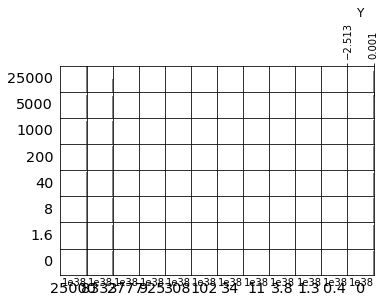

In [4]:
fcs.plates['C6'][2].plot(channel_names=['Y']);

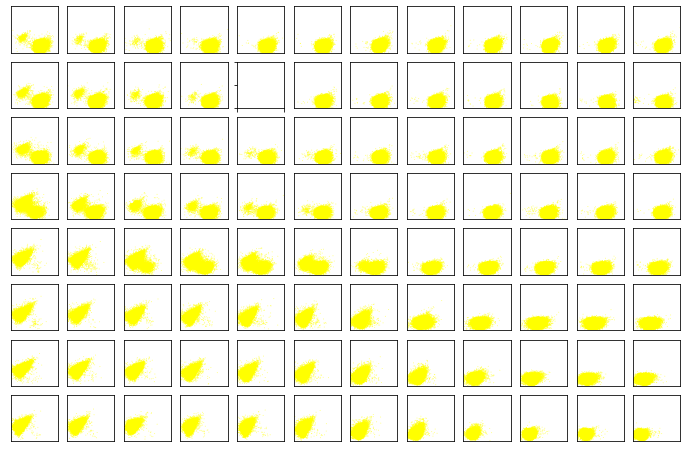

In [11]:
batch = 2
nrows,ncols = 8,12

fig, axs = subplots(nrows,ncols,
    figsize=(ncols,nrows),sharex=True,sharey=True)

for idx in fcs.plates['C6'][batch]:
    
    i = list(fcs.row_layout.values()).index(idx[0])
    j = list(fcs.col_layout.values()).index(idx[1])+1
    
    subplot(nrows,ncols,i*ncols+j)

    ax = fcs.plates['C12'][batch][idx].plot(channel_names=['Y','C'],
        kind='scatter', alpha=0.5, s=1, color='yellow', autolabel=False)

    ax = fcs.plates['C6'][batch][idx].plot(channel_names=['Y','C'],
        kind='scatter', alpha=0.5, s=1, color='cyan', autolabel=False)

    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    
    ax.axes.set_xlim(-1,7)
    ax.axes.set_ylim(-1,7)